In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import preprocessing, cluster
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt


In [2]:
df = sns.load_dataset('flights')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [3]:
df.head()


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [4]:
# Parent Class
class Sample:
    def __init__(self, df: pd.DataFrame):
        self.set_df(df)

    def get_sample(self):
        return self.sample_

    def set_df(self, df):
        self.df = df.reset_index(drop=['index'])
        self.sample_ = None
        return True

    def sample(self):
        return self.df


In [5]:
# Select random indices
class SimpleRandomSample(Sample):
    def sample(self, ratio=0.3):
        df_len = len(self.df)
        sample_idxs = np.random.choice(df_len, int(df_len*ratio))
        self.sample_ = self.df.iloc[sample_idxs].reset_index(drop=['index'])
        return self.sample_


In [6]:
# Cluster using appropriate columns and take sample from clusters
class ClusterSample(Sample):
    def sample(self, clusters=5, ratio=0.3):
        # Clustering
        numerical_cols = [cname for cname in self.df.columns
                          if is_numeric_dtype(self.df[cname])]
        s = (self.df.dtypes == 'object')
        object_cols = list(s[s].index)
        s = (self.df.dtypes == 'category')
        object_cols += list(s[s].index)
        _df = self.df[numerical_cols].copy()
        _df[object_cols] = preprocessing.OrdinalEncoder()\
            .fit_transform(df[object_cols])
        kmeans = cluster.KMeans(n_clusters=clusters)
        _df["Cluster"] = kmeans.fit_predict(_df)
        _df["Cluster"] = _df["Cluster"].astype("category")

        # Sampling
        _df_clusters = [_df[(_df["Cluster"] == i)].sample(frac=ratio)
                        for i in _df["Cluster"].unique()]
        self.sample_ = self.df.loc[pd.concat(_df_clusters).index]\
            .reset_index(drop=['index'])
        return self.sample_


In [7]:
# Sample using predefined intervals
class SystematicSample(Sample):
    def sample(self, ratio=0.3):
        df_len = len(self.df)
        step = int(np.round(1//ratio))
        sample_idxs = list(range(0, df_len, step))
        self.sample_ = self.df.iloc[sample_idxs].reset_index(drop=['index'])
        return self.sample_


In [8]:
# Stratify using one column then take samples from the strats formed
class StratifiedSample(Sample):
    def sample(self, cname=None, ratio=0.3):
        if not cname:
            cname = self.df.columns[0]
        # Stratification
        is_numerical = is_numeric_dtype(self.df[cname])
        _df = self.df.copy()
        if not is_numerical:
            _df["cname"] = preprocessing.OrdinalEncoder()\
                .fit_transform(df[[cname]])
        else:
            kmeans = cluster.KMeans()
            _df["Strata"] = kmeans.fit_predict(_df[[cname]])
            _df["Strata"] = _df["Strata"].astype("category")
        # Sampling
        _df_stratas = [_df[(_df["Strata"] == i)].sample(frac=ratio)
                       for i in _df["Strata"].unique()]
        self.sample_ = self.df.loc[pd.concat(_df_stratas).index]\
            .reset_index(drop=['index'])
        return self.sample_


In [9]:
# Sample is the first n indices
class ConvenienceSample(Sample):
    def sample(self, ratio=0.3):
        df_len = len(self.df)
        sample_idxs = list(range(0, int(np.ceil(df_len*ratio))))
        self.sample_ = self.df.iloc[sample_idxs].reset_index(drop=['index'])
        return self.sample_


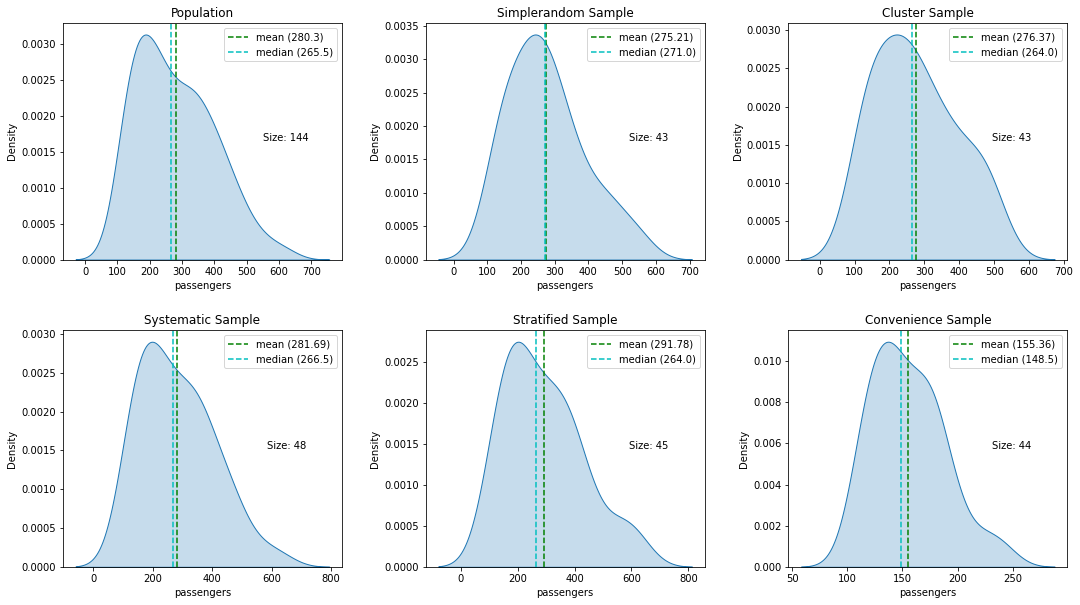

In [10]:
def createPlot(data, axis, title):
    sns.kdeplot(data, fill="b", ax=axis)
    mean, median = np.mean(data), np.median(data)
    axis.set_title(title)
    axis.axvline(mean, linestyle='--', color='g',
                 label=f'mean ({np.round(mean, 2)})')
    axis.axvline(median, linestyle='--', color='c',
                 label=f'median ({np.round(median, 2)})')
    axis.legend(loc='upper right')
    axis.text(0.8, 0.5, f'Size: {len(data)}',
              horizontalalignment='center',
              transform=axis.transAxes)


sampling_types = {
    'Population': Sample, 'Simplerandom Sample': SimpleRandomSample,
    'Cluster Sample': ClusterSample, 'Systematic Sample': SystematicSample,
    'Stratified Sample': StratifiedSample, 'Convenience Sample': ConvenienceSample}

items_len = len(sampling_types.keys())
rows = int(np.ceil(items_len/3))
cols = 3 if items_len >= 3 else items_len
fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, [sampling_title, sampling_class] in enumerate(sampling_types.items()):
    sample_obj = sampling_class(df)
    sample = sample_obj.sample()
    createPlot(sample['passengers'], axes[int(i//3), i % 3], sampling_title)
